<a href="https://colab.research.google.com/github/sw-programmer/Coursework1/blob/sangwoo/CW1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Coursework 1**

1.   ### **Computationally Efficient Eigenfaces**
2.   ### **Incremental PCA**
3.   ### **PCA-LDA for Face Recognition**
4.   ### **K-means codebook**
5.   ### **RF classifier**


**by 20190223	Soohyun Ryu,	20190247	Sangwoo Park**






**1. Setting!**

In [1]:
# import os
# import time
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import datetime
# import math
# import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mat_file = io.loadmat("/content/drive/MyDrive/CV_ML/CW1/face.mat")
mat_X = mat_file['X']
mat_Y = mat_file['l'][0]

print(mat_file.keys()) 
print(mat_X.shape)                         # 총 52명. 각 10장의 사진. 

dict_keys(['__header__', '__version__', '__globals__', 'X', 'l'])
(2576, 520)


In [32]:
df = pd.DataFrame(data=mat_X).transpose()
df['label'] = mat_Y                         # row -> data, col -> feature
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values                   # Target column

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    stratify=Y, 
                                                    random_state=1004)          
# 얼굴 그룹 비율 유지               
# test/train ratio = 0.2
# random_state -> before dividing, seed for shuffling
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
np.unique(y_train, return_counts=True)    # 52명의 얼굴이 80%씩 고르게 train set에 들어간 모습

X_train shape: (416, 2576)
X_test shape: (104, 2576)
y_train shape: (416,)
y_test shape: (104,)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52], dtype=uint8),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8]))

## **1. Computationally Efficient Eignefaces**



In [33]:
# 평균 얼굴 계산 함수 
def AvgCompute(X): 
  Xbar = np.mean(X, axis=0)  
  matrix_A = X - Xbar 
  return matrix_A, Xbar

# 고유값, 고유벡터 계산 함수
def eig(S): 
  eig_vals, eig_vecs = np.linalg.eig(S) 
  sort_indices = np.argsort(eig_vals)[::-1] # 내림차순 정렬 
  return eig_vals[sort_indices], eig_vecs[:, sort_indices]

# Reconstruction에 쓰일 함수
def reconstruct(X, PC):
  return (X @ PC) @ PC.T 

# PCA 과정
def PCA(X, num_components, condition=1): # X == train set, num_components == 선택할 eigen vectoe 개수, condition == 1 -> low, otherwise high
  N, D = X.shape 
  matrix_A, X_bar = AvgCompute(X)
  if condition == 1 : 
    S = (matrix_A @ matrix_A.T) / N
  else: 
    S = (matrix_A.T @ matrix_A) / N
  eig_vals, eig_vecs = eig(S) 
  
  principal_vals, principal_components = np.real(eig_vals[:num_components]), np.real(eig_vecs[:,:num_components]) 
  
  reconst_X = reconstruct(matrix_A, principal_components) + X_bar
  reconst_Err = np.sqrt( np.sum( np.square( reconst_X - X ) ))
  
  Projected_X = X @ principal_components

  return Projected_X, X_bar, principal_components, reconst_Err

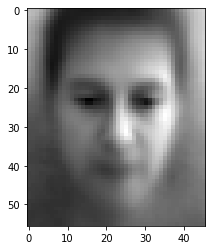

In [34]:
A, X_bar = AvgCompute(X_train) 
A = A.T

plt.imshow(np.reshape(X_bar,(46,56)).T, cmap = 'gist_gray') # 평균 얼굴 출력

In [35]:
### 1. S=(1/N)AAT 방식 ###
row, col = X_train.shape
S = (A @ A.T) / row
eigvals_hi, eigvecs_hi = eig(S) # High dimnesional
eigvals_hi = np.real(eigvals_hi)
eigvecs_hi = np.real(eigvecs_hi)

print(eigvals_hi.shape)

(2576,)


In [36]:
### 2.  (1/N)ATA 방식 ###
S = (A.T @ A) / row
eigvals_lo, eigvecs_lo = eig(S) # Low dimnesional
eigvals_lo = np.real(eigvals_lo)
eigvecs_lo = np.real(eigvecs_lo)

print(eigvals_lo.shape)

(416,)


* Pros : Effieciency of Computation
* Cons : 선택할 수 있는 EigenVector 수가 적다(?) -> Less accurate



[ 0.01472612  0.01568776  0.01620521 ... -0.00386158 -0.00348498
 -0.00338921]
[-0.01472612 -0.01568776 -0.01620521 ...  0.00386158  0.00348498
  0.00338921]


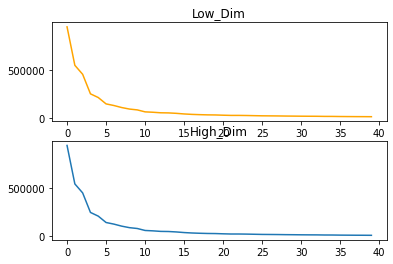

In [37]:
### eigval / eigvec 비교 ###
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.title('Low_Dim')
ax1.plot(range(0,40), eigvals_lo[:40], color='orange')	
ax2 = fig.add_subplot(212)
plt.title('High_Dim')
ax2.plot(range(0,40), eigvals_hi[:40])	 # 두 방식에서 eigenvalue 그래프가 동일함

low = A @ eigvecs_lo[:,0]
print(eigvecs_hi[:,0])
print(low/np.linalg.norm(low))             # low dim에서 A를 곱해주면 eigenvector 방향까지 동일해짐

653.1002589108444


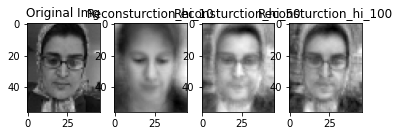

In [40]:
### Face Reconstruction ### 
# with 10 components

reconstruct_hi_10 = reconstruct(A.T, eigvecs_hi[:,0:10])
reconstruct_hi_10 = reconstruct_hi_10 + X_bar

# with 50 components
reconstruct_hi_50 = reconstruct(A.T, eigvecs_hi[:,0:50])   
reconstruct_hi_50 = reconstruct_hi_50 + X_bar

# with 100 components
reconstruct_hi_100 = reconstruct(A.T, eigvecs_hi[:,0:100])   
reconstruct_hi_100 = reconstruct_hi_100 + X_bar

fig = plt.figure()
ax1 = fig.add_subplot(141)
ax1.set_title('Original Img')
ax1.imshow(np.reshape(X_train[0,:],(46,56)).T, cmap = 'gist_gray')	
ax2 = fig.add_subplot(142)                
ax2.set_title('Reconsturction_hi_10')
ax2.imshow(np.reshape(reconstruct_hi_10[0,:],(46,56)).T, cmap = 'gist_gray')
ax3 = fig.add_subplot(143)
ax3.set_title('Reconsturction_hi_50')
ax3.imshow(np.reshape(reconstruct_hi_50[0,:],(46,56)).T, cmap = 'gist_gray')
ax4 = fig.add_subplot(144)
ax4.set_title('Reconsturction_hi_100')
ax4.imshow(np.reshape(reconstruct_hi_100[0,:],(46,56)).T, cmap = 'gist_gray')